# Sea Ice Spiral with EUMETSAT OSI SAF data

We access the daily Sea Ice Index (OSI-420) from the EUMETSAT OSI SAF (https://osi-saf.eumetsat.int) and plot it first as a "classic" timeseries plot, then as a spiral (inspired from the original work of Ed Hawkins).

This notebook also demonstrates access to the OSI SAF Sea Ice Index via OpenDap and xarray, as well as matplotlib's polar plot.

This was a fun side project, the first with my daughter (age 11) :-). 

#### Inspiration
Ed Hawkins original Temperature spiral: https://www.climate-lab-book.ac.uk/2016/spiralling-global-temperatures/

Other great sea-ice spirals (from NSIDC data):
* https://www.climate-lab-book.ac.uk/2017/animating-global-sea-ice-changes/
* https://svs.gsfc.nasa.gov/5028
* https://github.com/rec3141/seaicespiral

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pylab as plt
from matplotlib import cm
from matplotlib import ticker
import calendar


In [2]:
months = []
for i in range(1,13):
    months.append(calendar.month_name[i][:3])
    
source = "EUMETSAT OSI SAF data with R&D input from ESA CCI"
version = 'v2.2'
area = 'sh'

## Read Sea Ice Extent data

In [3]:
url = "https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/index/v2p2/{a:}/osisaf_{a:}_sie_daily.nc".format(a=area)

In [4]:
ds = xr.open_dataset(url)

In [5]:
print("Last data point: {}".format(np.datetime_as_string(ds['time'].values[-1])))

Last data point: 2024-09-08T00:00:00.000000000


## First plot

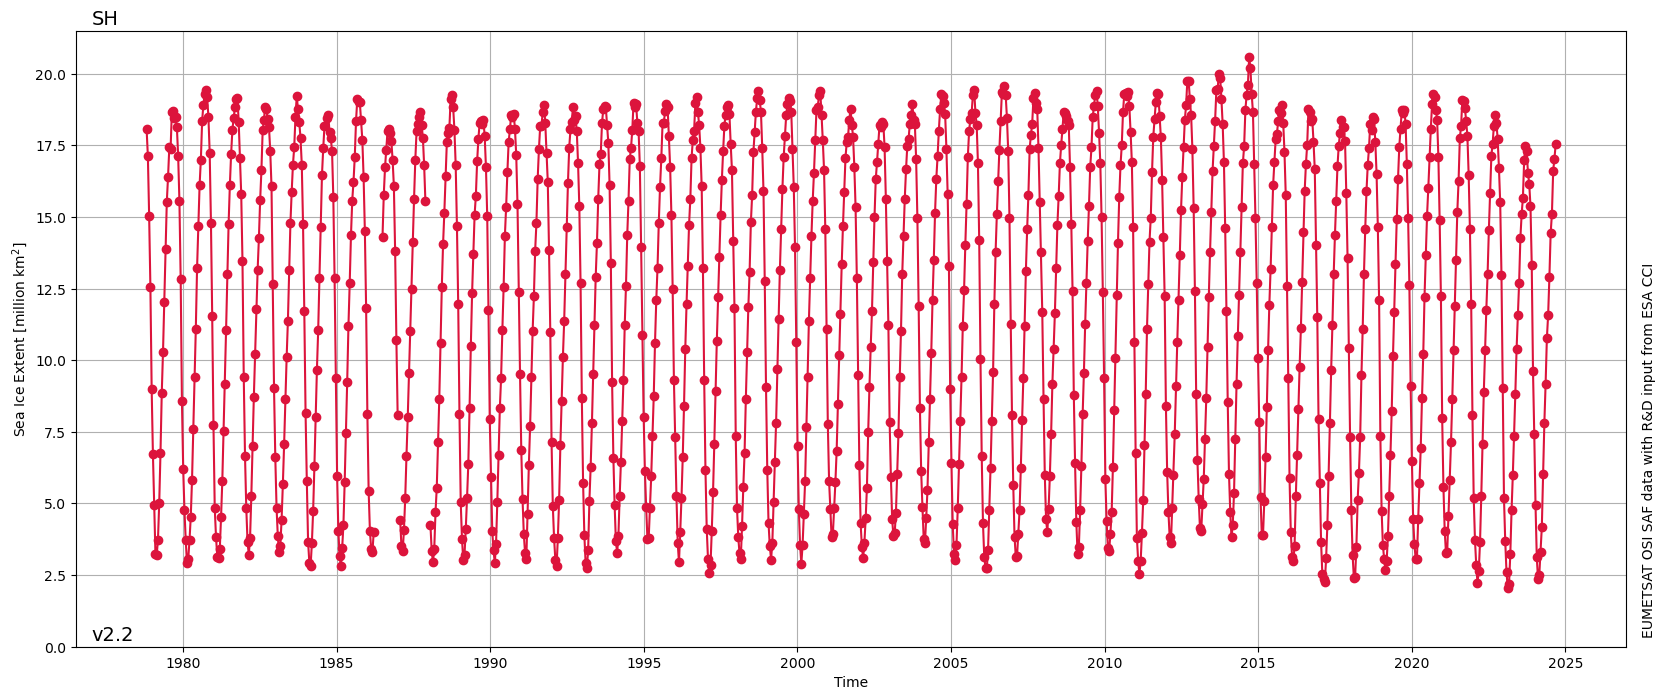

In [7]:
plt.plot_date(ds['time'][::15],ds['sie'][::15],ls='-',color='crimson',)
fig = plt.gcf()
fig.set_size_inches((20,8))
ax = plt.gca()
ax.set_xlabel('Time')
ax.set_ylabel(r"Sea Ice Extent [million km$^2$]")
ax.set_ylim(0,None)
ax.grid()

ax.text(0.01,0.01,version,fontsize=14,transform=ax.transAxes)
ax.text(1.01, 0.02, source, rotation=90,transform=ax.transAxes)
ax.text(0.01,1.01,area.upper(),fontsize=14,transform=ax.transAxes)

plt.show()

## Timeseries plot by year

In [8]:
ds_year = ds.groupby('time.year')

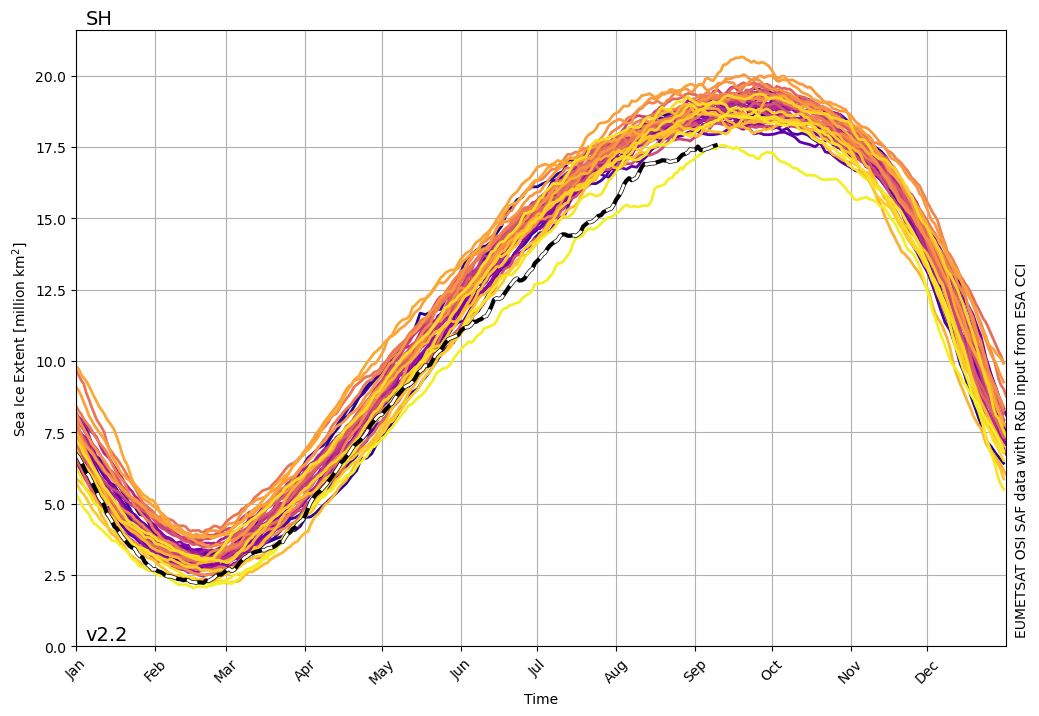

In [9]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

years = np.array(list(ds_year.groups.keys()))
for year in years:
    one_year = ds_year[year]
    
    yfrac = ( year - years.min() ) / ( years.max()-years.min() )
    
    if year == years[-1]:
        ax.plot(one_year['time.dayofyear'], one_year['sie'], ls='-', marker=None, color='k', lw=3)
        ax.plot(one_year['time.dayofyear'], one_year['sie'], dashes=[4, 4], marker=None, color='white', lw=2)
    else:
        col = cm.plasma( yfrac )
        ax.plot(one_year['time.dayofyear'], one_year['sie'], ls='-', marker=None, color=col, lw=2)

months_tick = [1,]
for i in range(1,12):
    months_tick.append(calendar.monthrange(1970, i)[1])
months_tick = np.array(months_tick)  
months_tick = months_tick.cumsum()

    
ax.set_ylim(0,None)
ax.set_xlim(1,366)
ax.set_xlabel('Time')
ax.set_ylabel(r"Sea Ice Extent [million km$^2$]")
ax.set_xticks(months_tick)
ax.set_xticklabels(months, rotation=45)
ax.grid()

ax.text(0.01,0.01,version,fontsize=14,transform=ax.transAxes)
ax.text(1.01, 0.02, source, rotation=90,transform=ax.transAxes)
ax.text(0.01,1.01,area.upper(),fontsize=14,transform=ax.transAxes)

plt.savefig('./osisaf_sie_{a:}_timeseries.png'.format(a=area), bbox_inches='tight', facecolor='white')

plt.show()



## Spiral plot

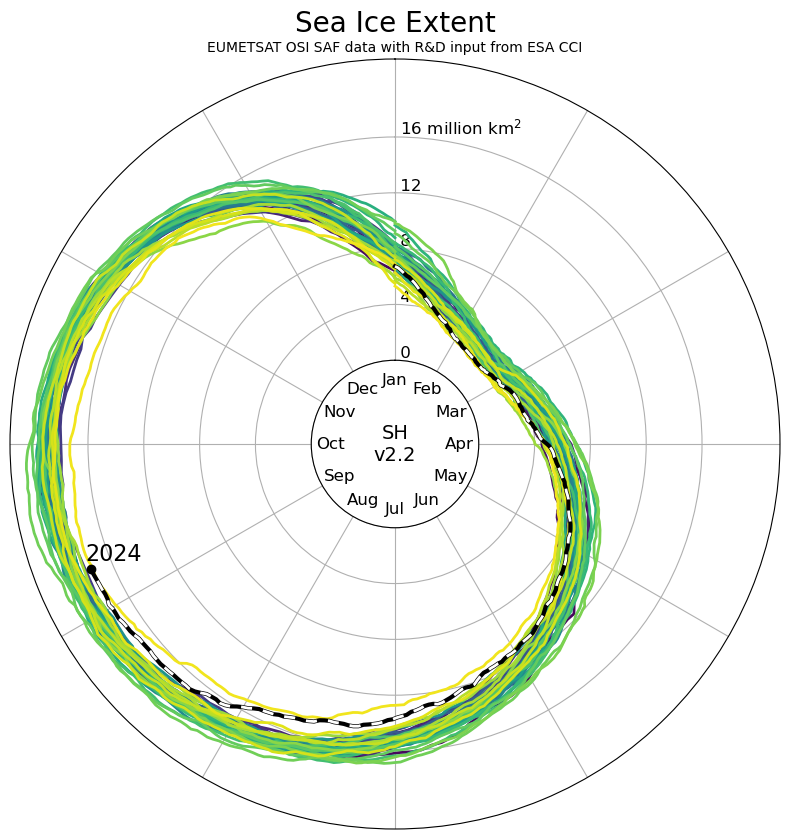

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
fig.set_size_inches((10,10))

years = np.array(list(ds_year.groups.keys()))
for year in years:
    if year < 1979:
        continue
    one_year = ds_year[year]
    
    yfrac = ( year - years.min() ) / ( years.max()-years.min() )
    doy = one_year['time.dayofyear']
    phi = (doy - doy.min()) / (365 + calendar.isleap(year) - doy.min()) * 2 * np.pi
    
    if year == years[-1]:
        col = 'k'
        ax.plot(phi, one_year['sie'], ls='-', marker=None, color=col, lw=3)
        ax.plot(phi, one_year['sie'], dashes=[4,4], marker=None, color='w', lw=2)
        ax.plot(phi[-1], one_year['sie'][-1], marker='o', color=col, lw=2)
        ax.text(phi[-1], one_year['sie'][-1]*0.9, year, color=col, fontsize=16, ha='center')
    else:
        col = cm.viridis( yfrac )
        ax.plot(phi, one_year['sie'], ls='-', marker=None, color=col, lw=2)


months_tick = np.arange(1,13)
months_tick = (months_tick - 1) / 12.
months_tick *= 2 * np.pi

rticks = np.arange(0,18+0.1,4)
rticklabels = [' '+str(int(s)) for s in rticks]
rticklabels[-1] += ' million km$^2$'
ax.set_rgrids(rticks, labels=rticklabels,fontsize=12)

ax.set_xticks(months_tick)
ax.set_xticklabels(months, fontsize=12)
ax.set_rlabel_position(0)

ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax.set_rorigin(-6)

ax.tick_params(labelleft=True, labelright=False,
               labeltop=True, labelbottom=False)

ax.set_title('Sea Ice Extent', pad=20, fontsize=20)
ax.text(0.5, 1.01, source, ha='center', transform=ax.transAxes)
ax.text(0.5,0.5,area.upper()+'\n'+version,ha='center',va='center',fontsize=14,transform=ax.transAxes)

ax.grid(True)

plt.savefig('./osisaf_sie_{a:}_spiral.png'.format(a=area), bbox_inches='tight', facecolor='white')

plt.show()

There are for sure many ways to make this spiral look better. You are welcome to add suggestions or even send a PR.